<a href="https://colab.research.google.com/github/matin/garth/blob/main/colabs/sleep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin sleep statistics

Start by installing and importing `garth`

In [1]:
%pip install garth >& /dev/null

In [2]:
import garth

Define Garth session location to save and resume sessions

In [3]:
GARTH_HOME = 'drive/MyDrive/garth'

Mount Drive for saving and resuming sessions

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Resume session or login, and make sure to save the garth session for next time

In [5]:
from garth.exc import GarthException
from getpass import getpass
from requests import HTTPError

try:
    garth.resume(GARTH_HOME)
    garth.client.username
except (GarthException, HTTPError, FileNotFoundError):
    email = input("Email: ")
    password = getpass("Password: ")
    garth.client.login(email, password)

garth.save(GARTH_HOME)

## Daily sleep quality

List sleep quality for the past 7 days

In [6]:
garth.DailySleep.list(period=7)

[DailySleep(calendar_date=datetime.date(2023, 7, 29), value=74),
 DailySleep(calendar_date=datetime.date(2023, 7, 30), value=64),
 DailySleep(calendar_date=datetime.date(2023, 7, 31), value=29),
 DailySleep(calendar_date=datetime.date(2023, 8, 1), value=88),
 DailySleep(calendar_date=datetime.date(2023, 8, 2), value=62),
 DailySleep(calendar_date=datetime.date(2023, 8, 3), value=59)]

Let's take a look at the sleep quality for the past 90 days

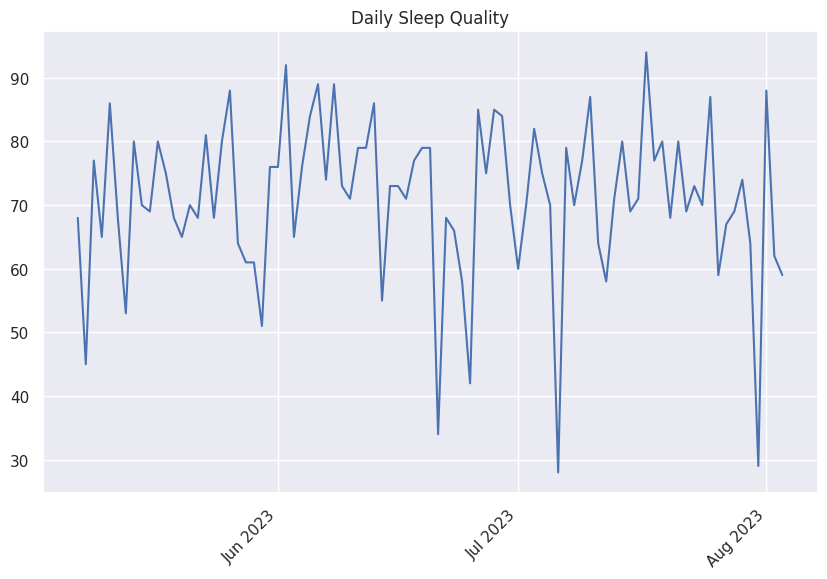

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

daily_sleep = pd.DataFrame(garth.DailySleep.list(period=90))

daily_sleep['calendar_date'] = pd.to_datetime(daily_sleep['calendar_date'])
daily_sleep.set_index('calendar_date', inplace=True)

sns.set_theme()

plt.figure(figsize=(10, 6))

sns.lineplot(data=daily_sleep, legend=False)

plt.ylabel(None)
plt.xlabel(None)
plt.title('Daily Sleep Quality')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xticks(rotation=45, ha='right')

plt.show()

## Daily sleep data (including stages)

The sleep data includes a tremendous amount of information and can only be fetched by day. Let's fetch every day for the 30 days leading up to yesterday

In [8]:
from datetime import date, timedelta
sleep_data = garth.SleepData.list(date.today() - timedelta(days=1), days=90)

The data is nested, so we'll need to flatten it to be able to get it into a usable DataFrame

In [9]:
import pandas as pd
from pydantic import BaseModel
from typing import List, Union
from dataclasses import is_dataclass

def dataclass_to_dict(dataclass_instance: Union[BaseModel, list]):
    if isinstance(dataclass_instance, list):
        return [dataclass_to_dict(item) for item in dataclass_instance]
    elif is_dataclass(dataclass_instance):
        return {k: dataclass_to_dict(v) for k, v in dataclass_instance.__dict__.items()}
    else:
        return dataclass_instance

def dataclass_to_dataframe(dataclass_list: List[BaseModel]) -> pd.DataFrame:
    dict_list = dataclass_to_dict(dataclass_list)
    return pd.json_normalize(dict_list)

Let's graph the sleep stages as a stacked bar graph

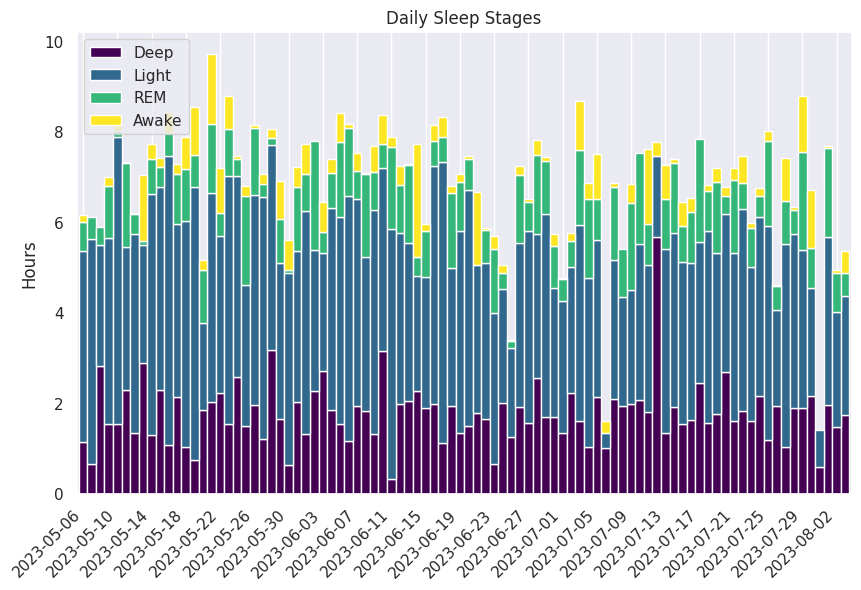

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = dataclass_to_dataframe(sleep_data)

df["daily_sleep_dto.deep_sleep_hours"] = (
    df["daily_sleep_dto.deep_sleep_seconds"] / 3600
)
df["daily_sleep_dto.light_sleep_hours"] = (
    df["daily_sleep_dto.light_sleep_seconds"] / 3600
)
df["daily_sleep_dto.rem_sleep_hours"] = (
    df["daily_sleep_dto.rem_sleep_seconds"] / 3600
)
df["daily_sleep_dto.awake_sleep_hours"] = (
    df["daily_sleep_dto.awake_sleep_seconds"] / 3600
)
df["daily_sleep_dto.calendar_date"] = (
    pd.to_datetime(df["daily_sleep_dto.calendar_date"]).dt.date
)

df.sort_values("daily_sleep_dto.calendar_date", inplace=True)
df.set_index("daily_sleep_dto.calendar_date", inplace=True)
df.rename(columns={
    'daily_sleep_dto.deep_sleep_hours': 'Deep',
    'daily_sleep_dto.light_sleep_hours': 'Light',
    'daily_sleep_dto.rem_sleep_hours': 'REM',
    'daily_sleep_dto.awake_sleep_hours': 'Awake'
}, inplace=True)

sns.set_theme()

ax = df[['Deep', 'Light', 'REM', 'Awake']].plot(
    kind='bar', stacked=True, figsize=(10, 6), grid=True, colormap='viridis',
    width=1
)

plt.ylabel("Hours")
plt.xlabel(None)
plt.title("Daily Sleep Stages")
plt.grid(axis='y')
plt.legend(loc='upper left')
labels = ax.get_xticklabels()
ticks = ax.get_xticks()
ax.set_xticks([tick for i, tick in enumerate(ticks) if i % 4 == 0])
ax.set_xticklabels([label for i, label in enumerate(labels) if i % 4 == 0])
plt.xticks(rotation=45, ha='right')

plt.show()